## Sleep stage classification from polysomnography (PSG) data

In [45]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

## Load PSG data

In [231]:
n_subjects = 2
subject_ids = list(range(n_subjects))
sleep_data_files = fetch_data(subjects=subject_ids, recording=[1])

data_format = "edf"
data_readers = {
    "edf": mne.io.read_raw_edf
}

Using default location ~/mne_data for PHYSIONET_SLEEP...


In [241]:
def load_psg_sample(data_files, data_reader):
    raw_data = data_reader(
        data_files[0], stim_channel="Event marker", infer_types=True, preload=True
    )

    annot_data = mne.read_annotations(data_files[1])
    raw_data.set_annotations(annot_data, emit_warning=False)

    return raw_data, annot_data


In [242]:
raw_train, annotations_train = load_psg_sample(sleep_data_files[0], data_readers[data_format])
raw_test, annotations_test = load_psg_sample(sleep_data_files[1], data_readers[data_format])

Extracting EDF parameters from /Users/maxverbiest/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Extracting EDF parameters from /Users/maxverbiest/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'R

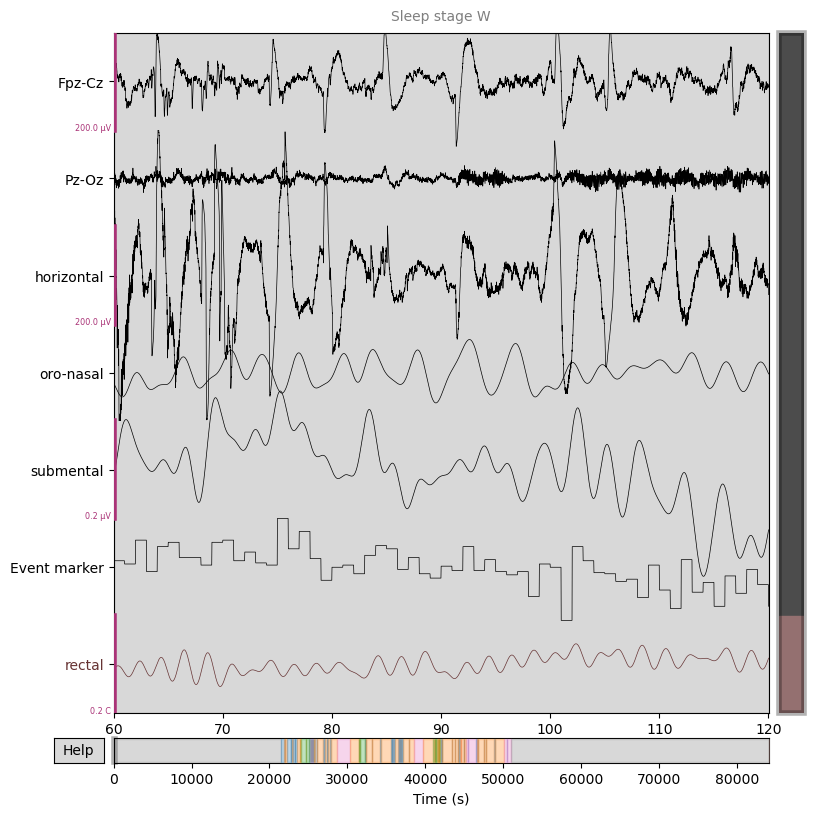

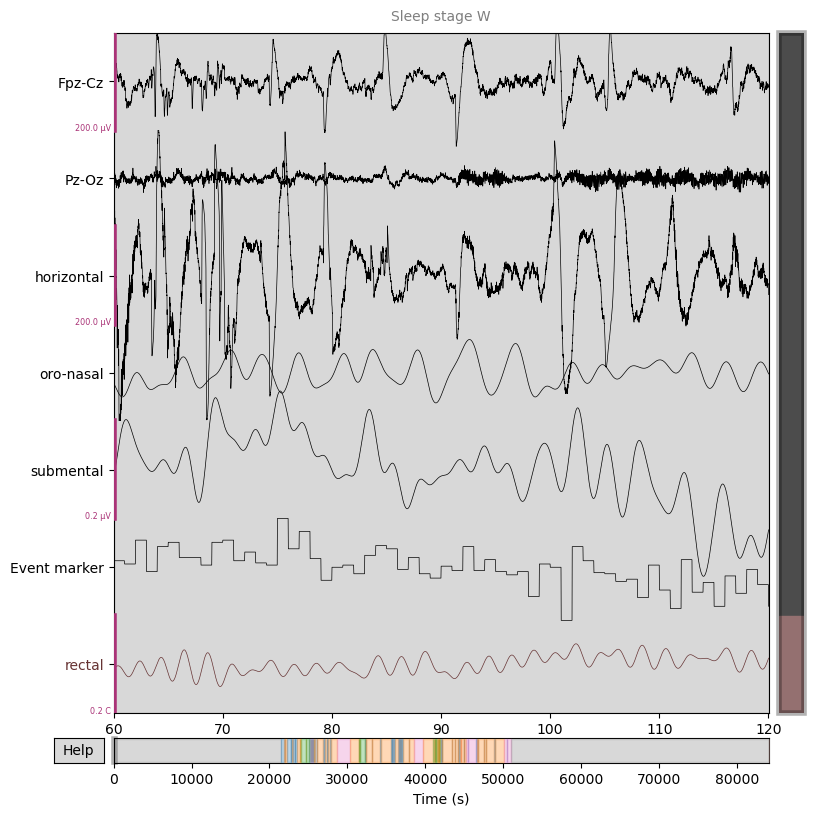

In [240]:
raw_test.plot(
    start=60,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1)
)

## Extract 30s events from annotations

In [244]:
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annotations_train.crop(annotations_train[1]["onset"] - (30 * 60), annotations_train[-2]["onset"] + (30 * 60))
raw_train.set_annotations(annotations_train, emit_warning=False)
events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

annotations_test.crop(annotations_test[1]["onset"] - (30 * 60), annotations_test[-2]["onset"] + (30 * 60))
raw_test.set_annotations(annotations_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


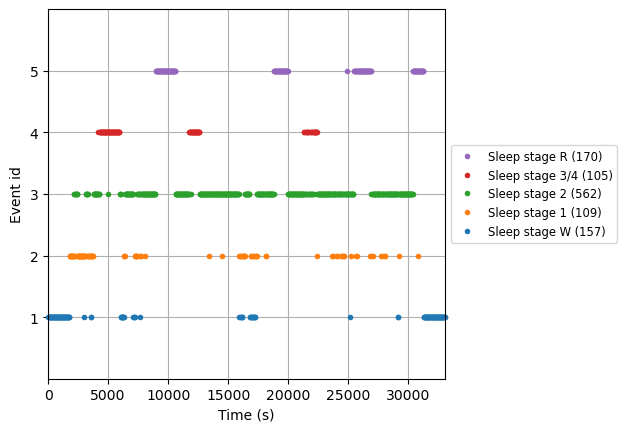

In [247]:
# create a new event_id that unifies stages 3 and 4
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

# plot events
fig = mne.viz.plot_events(
    events_test,
    event_id=event_id,
    sfreq=raw_test.info["sfreq"],
    first_samp=events_test[0, 0],
)

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Create Epochs from the data based on the events found in the annotations

In [249]:
tmax = 30.0 - (1.0 / raw_train.info["sfreq"])  # tmax is included

epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_train

epochs_test = mne.Epochs(
    raw=raw_test,
    events=events_test,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_test

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~13 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


Using data from preloaded Raw for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 109 events and 3000 origina

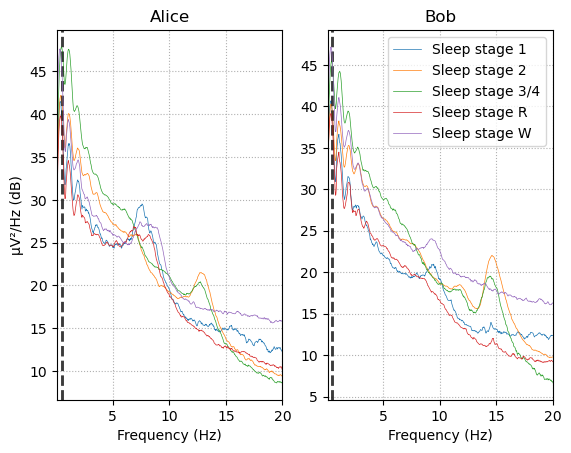

In [253]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2], ["Alice", "Bob"], [epochs_train, epochs_test]):
    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.0)
        spectrum.plot(
            ci=None,
            color=color,
            axes=ax,
            show=False,
            average=True,
            spatial_colors=False,
            picks="data",
            exclude="bads",
        )
    ax.set(title=title, xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)
plt.show()

In [254]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5] -> actually [n_samples, 5 * n_traces], [[eeg1_fb1, eeg2_fb1 ..., eeg1_fbn, eeg2_fbn, ...], ...]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [255]:
pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Using data from preloaded Raw for 841 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1103 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6854034451495921


In [142]:
y_pred = pipe.predict(epochs_train)
y_test = epochs_train.events[:, 2]
acc = accuracy_score(y_test, y_pred)
print(acc)

Using data from preloaded Raw for 841 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
1.0


In [259]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2,3,4
0,154,1,0,2,0
1,71,25,8,1,4
2,47,33,437,25,20
3,0,0,4,101,0
4,51,63,17,0,39


In [257]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.48      0.98      0.64       157
  Sleep stage 1       0.20      0.23      0.22       109
  Sleep stage 2       0.94      0.78      0.85       562
Sleep stage 3/4       0.78      0.96      0.86       105
  Sleep stage R       0.62      0.23      0.33       170

       accuracy                           0.69      1103
      macro avg       0.60      0.64      0.58      1103
   weighted avg       0.74      0.69      0.68      1103



In [260]:
from sklearn.neural_network import MLPClassifier

In [267]:
mlp_pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    MLPClassifier(hidden_layer_sizes=(100)),
)

# Train
y_train = epochs_train.events[:, 2]
mlp_pipe.fit(epochs_train, y_train)

# Test
y_pred = mlp_pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Using data from preloaded Raw for 841 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1103 events and 3000 original time points ...


/Users/maxverbiest/miniconda3/envs/EEG-for-DSS/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.5095194922937444
